Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta1, beta2, beta3, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.


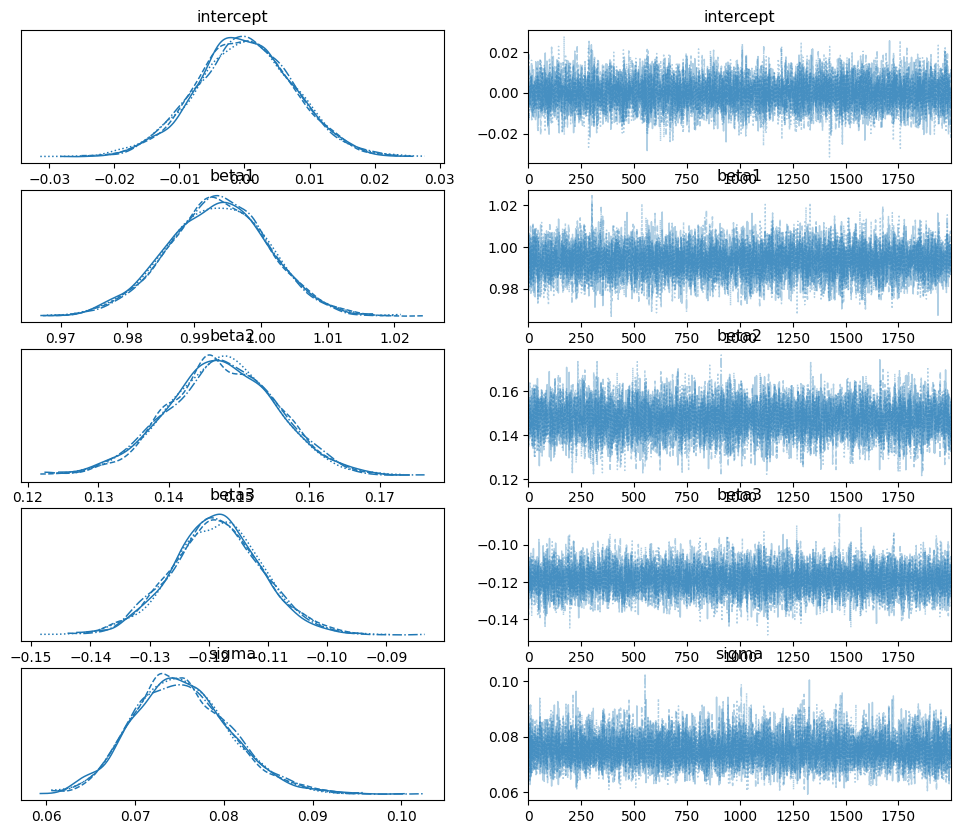

            mean     sd  hdi_3%  hdi_97%
intercept  0.000  0.008  -0.014    0.015
beta1      0.994  0.008   0.979    1.008
beta2      0.148  0.008   0.133    0.163
beta3     -0.119  0.008  -0.133   -0.104
sigma      0.075  0.005   0.066    0.086

Denormalized Coefficients:
Beta1 (Surface Area): 0.40 (thousands of euros per m²)
Beta2 (Rooms): 0.00 (thousands of euros per room)
Beta3 (Distance to Center): -0.00 (thousands of euros per km)
Intercept: 242.46 (thousands of euros)

Highest Density Intervals (95% HDI):
Beta1 (Surface Area): <bound method Mapping.values of <xarray.Dataset> Size: 64B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    beta1    (hdi) float64 16B 0.9779 1.008>
Beta2 (Rooms): <bound method Mapping.values of <xarray.Dataset> Size: 64B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    beta2    (hdi) float64 16B 0.1331 0.1636>
Beta3 (Distance to Center): <bound method Mapp

In [8]:

import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

file_path = 'real_estate_data.csv'
data = pd.read_csv(file_path)

x1 = data['Surface_area'].values
x2 = data['Rooms'].values
x3 = data['Distance_to_center'].values
y = data['Price'].values #dependenta

x1_norm = (x1 - x1.mean()) / x1.std()
x2_norm = (x2 - x2.mean()) / x2.std()
x3_norm = (x3 - x3.mean()) / x3.std()
y_norm = (y - y.mean()) / y.std()


with pm.Model() as model:
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=1)
    beta2 = pm.Normal("beta2", mu=0, sigma=1)
    beta3 = pm.Normal("beta3", mu=0, sigma=1)
    
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    mu = intercept + beta1 * x1_norm + beta2 * x2_norm + beta3 * x3_norm
    
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_norm)
    
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)
    
az.plot_trace(trace)
plt.show()

summary = az.summary(trace, kind="stats")
print(summary)

std_x1 = np.std(x1)
std_x2 = np.std(x2)
std_x3 = np.std(x3)
std_y = np.std(y)

beta1_posterior = trace.posterior['beta1'].values.flatten()
beta2_posterior = trace.posterior['beta2'].values.flatten()
beta3_posterior = trace.posterior['beta3'].values.flatten()
intercept_posterior = trace.posterior['intercept'].values.flatten()

beta1_denorm = beta1_posterior.mean() * (std_x1 / std_y)
beta2_denorm = beta2_posterior.mean() * (std_x2 / std_y)
beta3_denorm = beta3_posterior.mean() * (std_x3 / std_y)
intercept_denorm = intercept_posterior.mean() * std_y + y.mean() - (beta1_denorm * x1.mean()) - (beta2_denorm * x2.mean()) - (beta3_denorm * x3.mean())

print("\nDenormalized Coefficients:")
print(f"Beta1 (Surface Area): {beta1_denorm:.2f} (thousands of euros per m²)")
print(f"Beta2 (Rooms): {beta2_denorm:.2f} (thousands of euros per room)")
print(f"Beta3 (Distance to Center): {beta3_denorm:.2f} (thousands of euros per km)")
print(f"Intercept: {intercept_denorm:.2f} (thousands of euros)")

print("\nHighest Density Intervals (95% HDI):")
hdi_beta1 = az.hdi(trace.posterior['beta1'], hdi_prob=0.95)
hdi_beta2 = az.hdi(trace.posterior['beta2'], hdi_prob=0.95)
hdi_beta3 = az.hdi(trace.posterior['beta3'], hdi_prob=0.95)

print(f"Beta1 (Surface Area): {hdi_beta1.values}")
print(f"Beta2 (Rooms): {hdi_beta2.values}")
print(f"Beta3 (Distance to Center): {hdi_beta3.values}")